In [24]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob

main_path = "/disk1/luna16/"
working_path = "/disk1/luna16/output/"
one_img = "images_0599_0414.npy"
image=working_path + one_img
imgs_to_process = np.load(image).astype(np.float64) 
print ("on image", image)

on image /disk1/luna16/output/images_0599_0414.npy


(array([5.5772e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0520e+03,
        3.4638e+04, 5.1410e+03, 7.8170e+03, 1.3722e+04, 1.9142e+04,
        1.6787e+04, 1.0079e+04, 5.4900e+03, 2.9580e+03, 2.0490e+03,
        1.4430e+03, 1.1790e+03, 8.7700e+02, 6.7100e+02, 6.0000e+02,
        5.4000e+02, 4.0400e+02, 3.9600e+02, 3.6900e+02, 3.8400e+02,
        3.5200e+02, 3.1600e+02, 3.2800e+02, 2.9800e+02, 3.0600e+02,
        3.1400e+02, 3.5400e+02, 3.2900e+02, 3.52

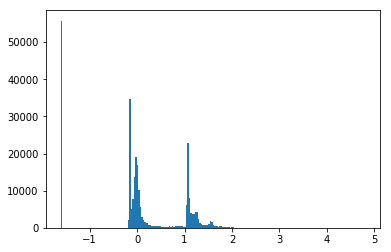

In [19]:
import matplotlib.pyplot as plt
img = imgs_to_process[0]
#Standardize the pixel values
mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std
plt.hist(img.flatten(),bins=200)

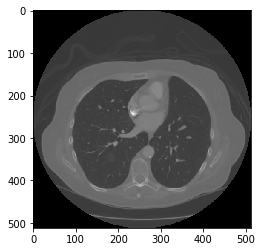

In [20]:
plt.imshow(img,cmap='gray')

We have to make sure that we set our threshold between the lung pixel values and the denser tissue pixel values.

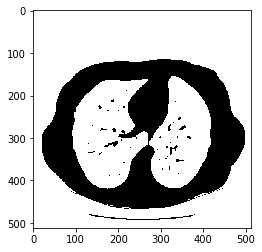

In [21]:
middle = img[100:400,100:400] 
mean = np.mean(middle)  
max = np.max(img)
min = np.min(img)
#move the underflow bins
img[img==max]=mean
img[img==min]=mean

kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

plt.imshow(thresh_img,cmap='gray')

# apply erosion and dilation

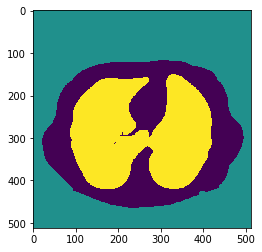

In [22]:
eroded = morphology.erosion(thresh_img,np.ones([4,4]))
dilation = morphology.dilation(eroded,np.ones([10,10]))
labels = measure.label(dilation)
label_vals = np.unique(labels)
plt.imshow(labels)

## lungs are generally far away from the top and bottom of the image, so any regions that are too close to the top and bottom are removed

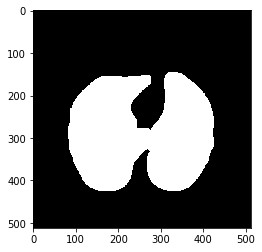

In [23]:
labels = measure.label(dilation)
label_vals = np.unique(labels)
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
    B = prop.bbox
    if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
        good_labels.append(prop.label)
mask = np.ndarray([512,512],dtype=np.int8)
mask[:] = 0
#
#  The mask here is the mask for the lungs--not the nodes
#  After just the lungs are left, we do another large dilation
#  in order to fill in and out the lung mask 
#
for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
plt.imshow(mask,cmap='gray')

# Applying the masks and cropping and resizing the image
applying the mask of the lung ROI to each of the images, cropping down to the bounding square of the lungs ROI, and then resizing the resulting image to 512 X 512.

In [26]:
sample_img = working_path+one_img

sample_mask = working_path + "lungmask_0599_0414.npy"
masks = np.load(sample_mask)
imgs = np.load(sample_img)
imgs = masks*imgs

## renormalizing the masked image (in the mask region)

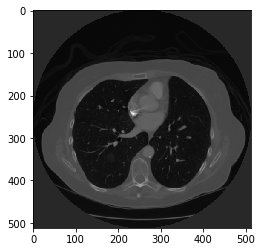

In [27]:
new_mean = np.mean(img[mask>0])  
new_std = np.std(img[mask>0])
#
#  Pushing the background color up to the lower end
#  of the pixel range for the lungs
#
old_min = np.min(img)       # background color
img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
img = img-new_mean
img = img/new_std
plt.imshow(img,cmap='gray')

## Writing out images and masks as 1 channel to feed into unet

In [28]:
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
val_i = int(0.1*num_images)

np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])

np.save(working_path+"valImages.npy",final_images[rand_i[val_i:test_i]])
np.save(working_path+"valMasks.npy",final_masks[rand_i[val_i:_test_i]])

np.save(working_path+"testImages.npy",final_images[rand_i[:val_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:val_i]])

NameError: name 'num_images' is not defined

# check roi isolating

image 0


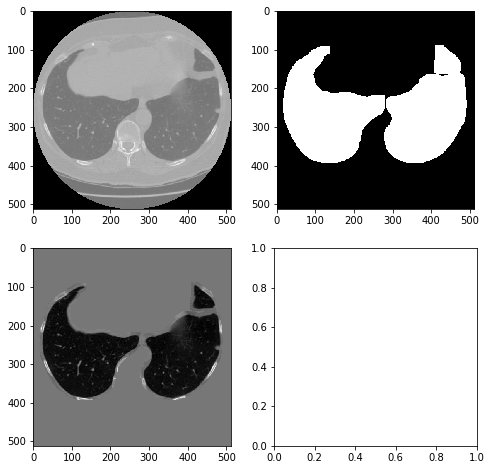

image 1


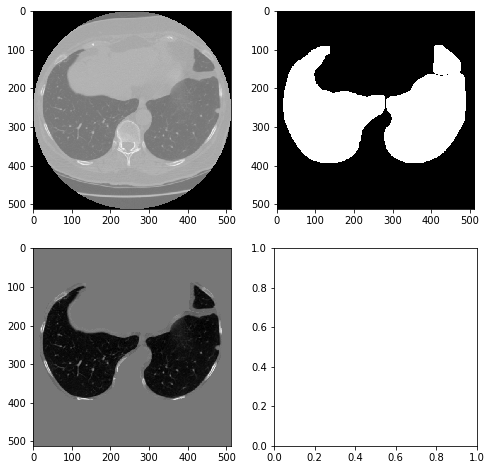

image 2


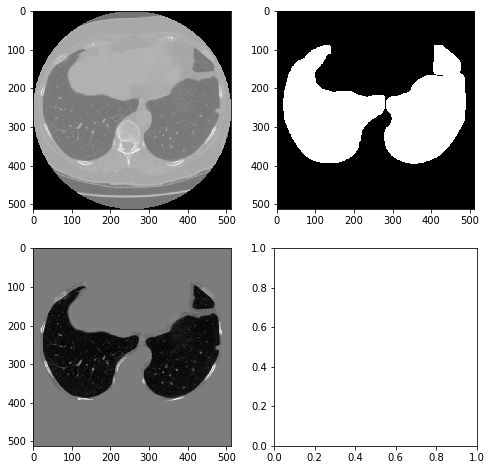

In [52]:
imgs = np.load(sample_img)
lungmask = np.load(sample_mask)

for i in range(len(imgs)):
    print ("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(lungmask[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*lungmask[i],cmap='gray')
    plt.show()